In [1]:
# Classifiers Models
import re 
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from collections import Counter
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier,
RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier, StackingClassifier)

# Preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler ,OneHotEncoder, MinMaxScaler, PolynomialFeatures

# model_selection
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, 
learning_curve, cross_val_predict, cross_validate, permutation_test_score, validation_curve, RandomizedSearchCV)

# Metrics
from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score,
root_mean_squared_error, recall_score, roc_auc_score, roc_curve, mean_absolute_error, auc, classification_report)

# Display all columns
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv('Customer_Attributes_and_Purchase_Propensity.csv', engine='pyarrow')

In [3]:
df.head()

,Age,Income,City,Marital_Status,Score,Purchased
0,56,24000,Houston,Divorced,0.479897,0
1,46,90588,Chicago,Single,0.685968,1
2,32,113610,Houston,Divorced,0.017380,0
3,60,117856,New York,Married,0.323131,0
4,25,58304,Houston,Single,0.973098,0


In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             500 non-null    int64  
 1   income          500 non-null    int64  
 2   city            500 non-null    object 
 3   marital_status  500 non-null    object 
 4   score           500 non-null    float64
 5   purchased       500 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 78.7 KB


In [6]:
df.isna().sum()

age               0
income            0
city              0
marital_status    0
score             0
purchased         0
dtype: int64

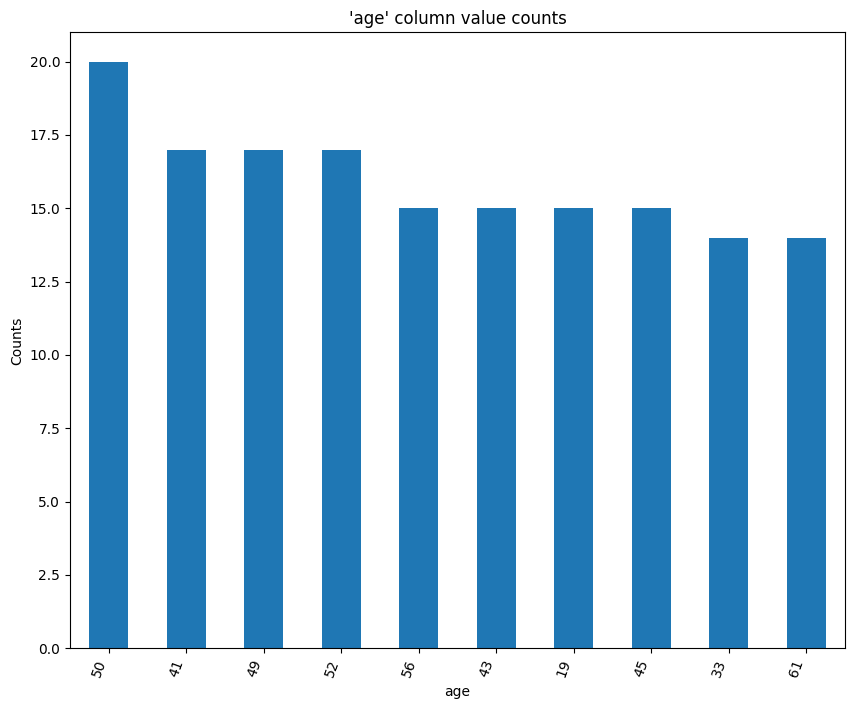

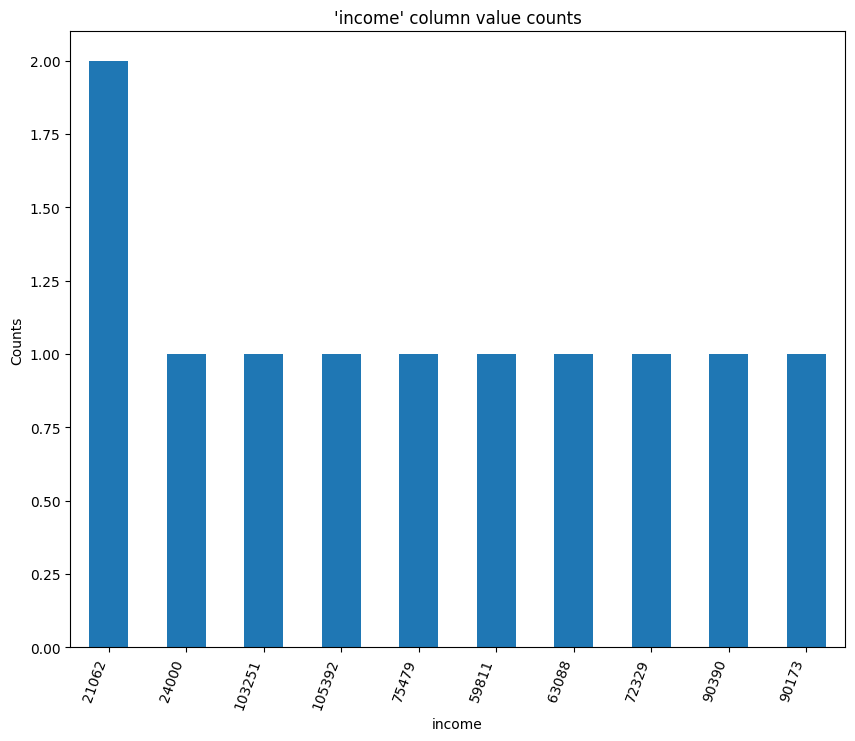

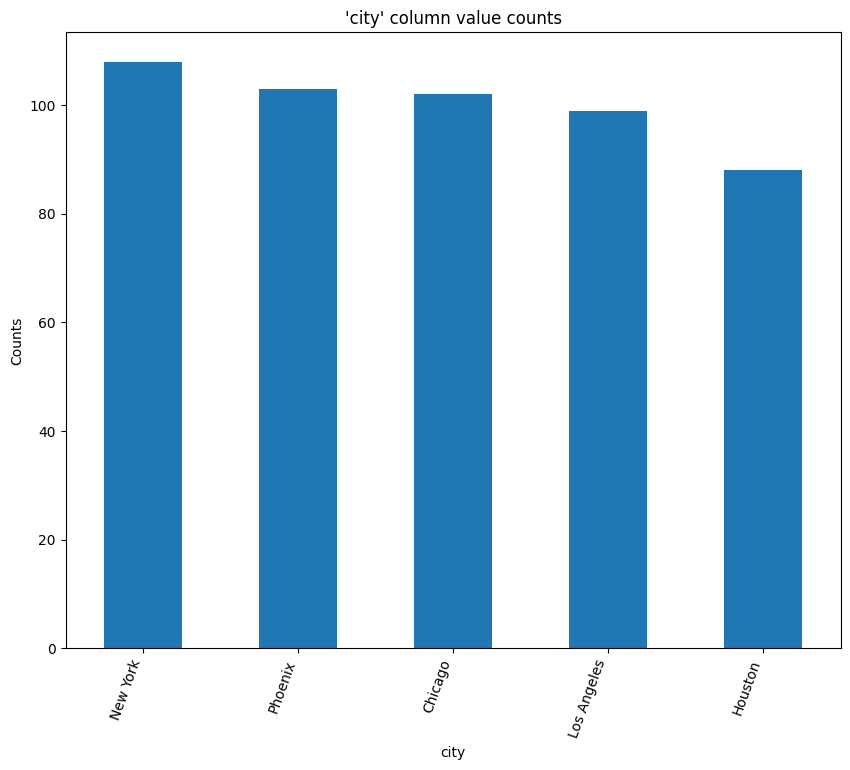

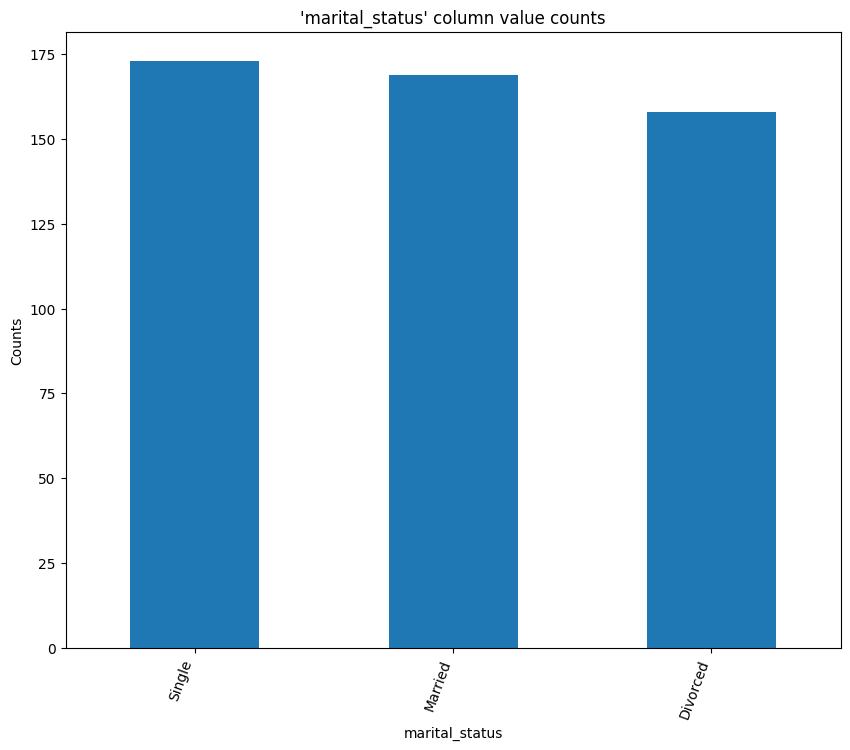

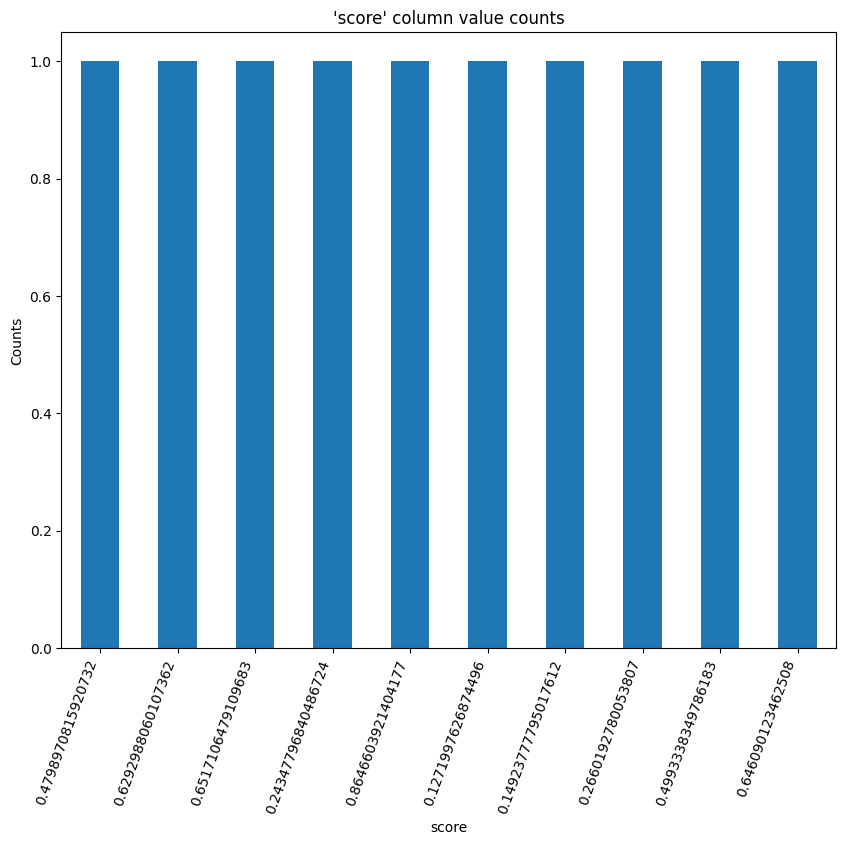

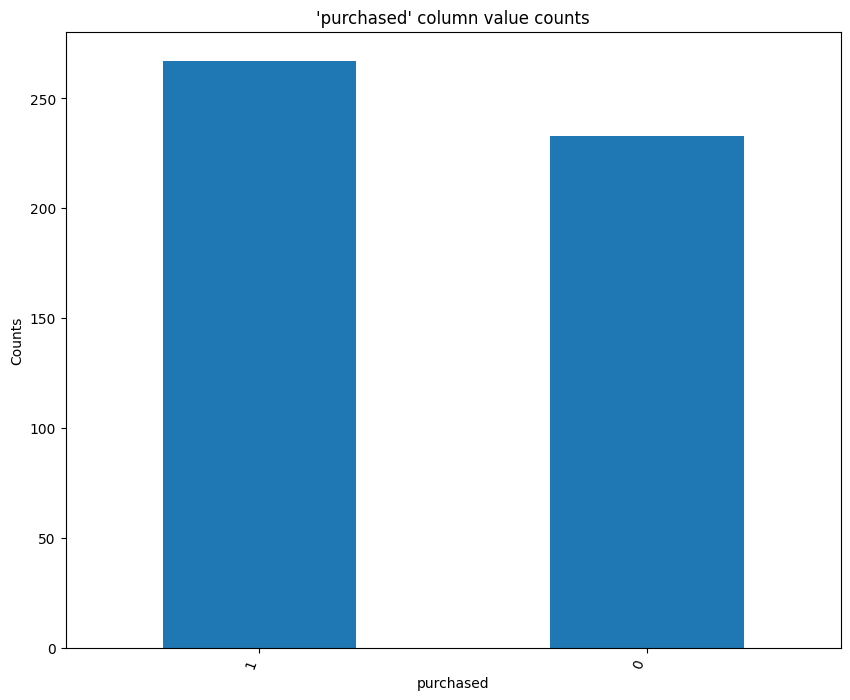

In [7]:
# Exploratory Data Analysis
def eda_plot(column, topn=10):
    plt.figure(figsize=(10, 8))
    df[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 70, ha='right')
    plt.show()

columns = df.columns

for column in columns:
    eda_plot(column)

In [8]:
df.head(3)

,age,income,city,marital_status,score,purchased
0,56,24000,Houston,Divorced,0.479897,0
1,46,90588,Chicago,Single,0.685968,1
2,32,113610,Houston,Divorced,0.017380,0


/var/folders/rk/vsbmyjqx09n87m8t22syxyvr0000gn/T/ipykernel_57861/934061954.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df['income'], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)


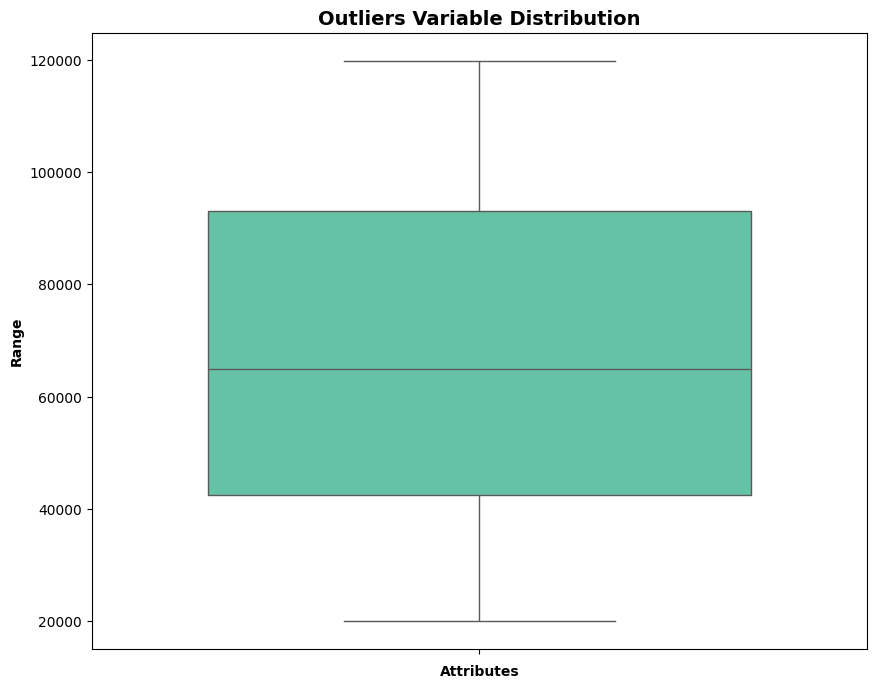

In [11]:
# Visualize Outlier Analysis one by one
# cols = ['unit_price', 'total_amount', 'shipping_cost', 'delivery_time_days'] 

plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df['income'], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');

In [13]:
df['marital_status'].value_counts()

marital_status
Single      173
Married     169
Divorced    158
Name: count, dtype: int64

In [14]:
df['purchased'].value_counts()

purchased
1    267
0    233
Name: count, dtype: int64

In [15]:
df.select_dtypes(include=['object', 'category'])

,city,marital_status
0,Houston,Divorced
1,Chicago,Single
2,Houston,Divorced
3,New York,Married
4,Houston,Single
...,...,...
495,Phoenix,Single
496,Los Angeles,Divorced
497,New York,Married
498,Houston,Married


In [16]:
# Option 2: Use a loop for multiple columns
categorical_cols = df.select_dtypes(include=['object', 'category'])
label_encoders = {} 

for col in categorical_cols: 
    le = LabelEncoder() 
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for potential inverse transform

In [17]:
df.drop(df.select_dtypes(include=['object', 'category']), axis=1, inplace=True)

In [19]:
df['purchased'].value_counts()

purchased
1    267
0    233
Name: count, dtype: int64

In [22]:
df.head()

,age,income,score,purchased,city_encoded,marital_status_encoded
0,56,24000,0.479897,0,1,0
1,46,90588,0.685968,1,0,2
2,32,113610,0.017380,0,1,0
3,60,117856,0.323131,0,3,1
4,25,58304,0.973098,0,1,2


In [20]:
# Oversampling (Increase minority class)
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.purchased == 1]
df_minority = df[df.purchased == 0]

df_minority_upsampled = resample(df_minority, 
                                replace=True,     # sample with replacement
                                n_samples=len(df_majority),    # to match majority class
                                random_state=42)

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

In [21]:
# Always reset index (it’s a must to do)
df_balanced = df_balanced.reset_index(drop=True) 

In [23]:
df = df_balanced

## LogisticRegression

Dataset shape: (534, 5)
Feature names: Index(['age', 'income', 'score', 'city_encoded', 'marital_status_encoded'], dtype='object')
Number of classes: 2
Class distribution: [267 267]

X Train shape: (427, 5)
Y Train shape: (427,)
X Test shape: (107, 5)
Y Test shape: (107,)
-------------------------------------------------------------------------------------------------------------------------------
--- Basic Model Performance ---
Accuracy test set: 0.4766
Accuracy train set: 0.5761

Classification Report:
Classification Report test set:
               precision    recall  f1-score   support

           0       0.43      0.67      0.53        46
           1       0.57      0.33      0.42        61

    accuracy                           0.48       107
   macro avg       0.50      0.50      0.47       107
weighted avg       0.51      0.48      0.46       107


Classification Report train set:
               precision    recall  f1-score   support

           0       0.58      0.67      0

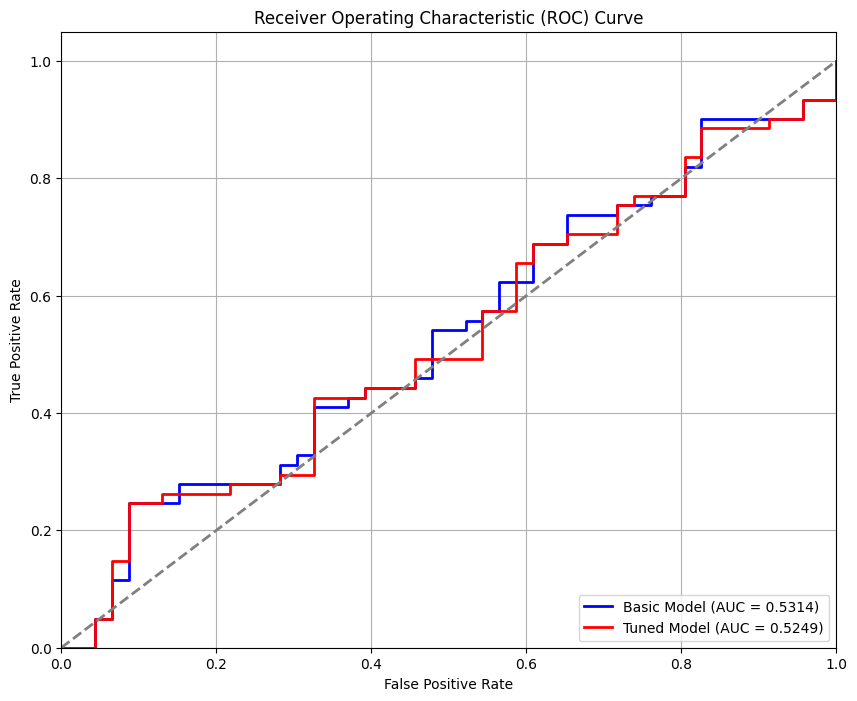

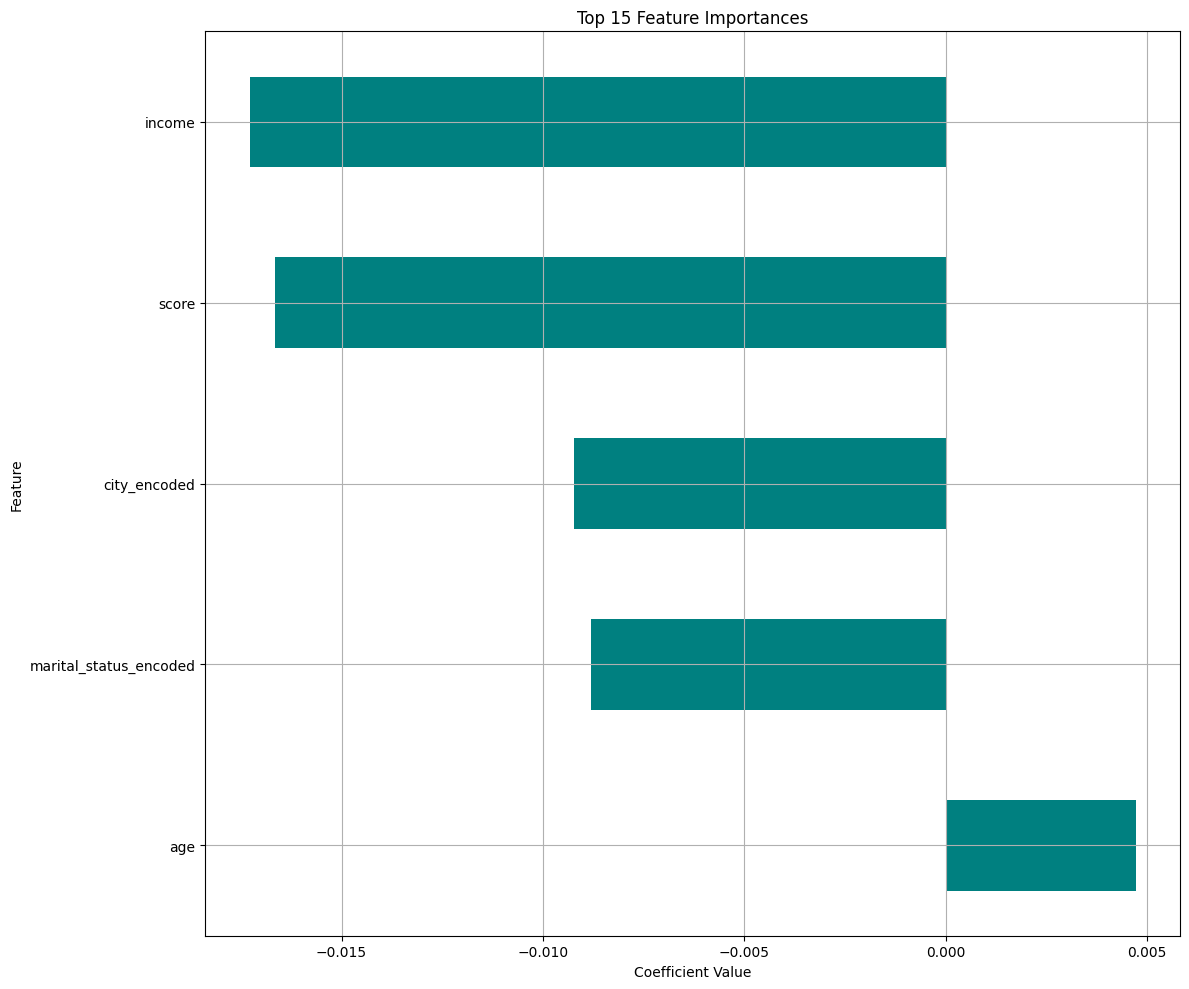

--- Top 10 Most Important Features ---
                        Coefficient
age                        0.004713
marital_status_encoded    -0.008801
city_encoded              -0.009223
score                     -0.016649
income                    -0.017282
--- Bottom 10 Least Important Features ---
                        Coefficient
age                        0.004713
marital_status_encoded    -0.008801
city_encoded              -0.009223
score                     -0.016649
income                    -0.017282
-------------------------------------------------------------------------------------------------------------------------------


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/py

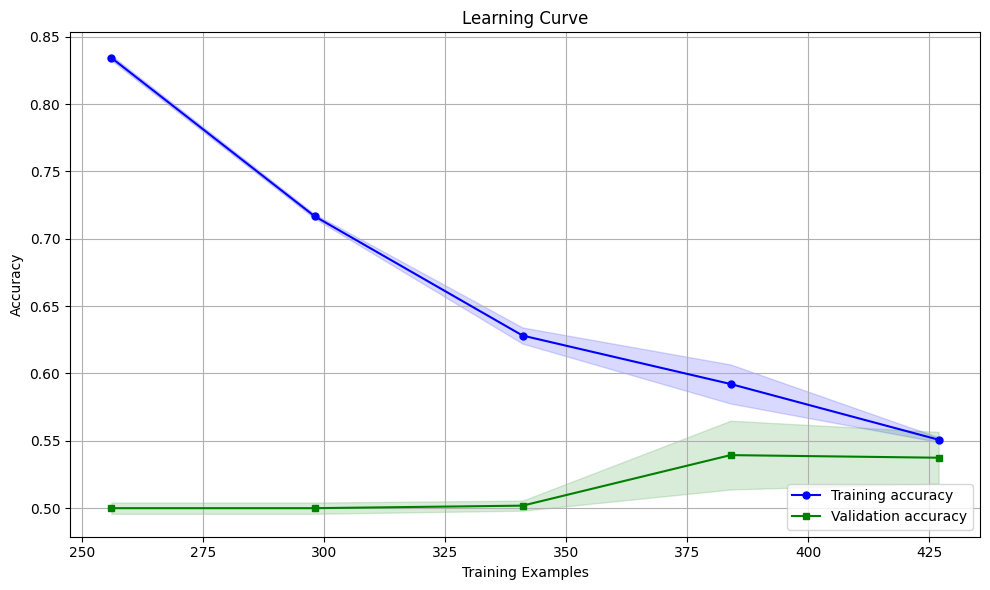

In [24]:
# Logistic Regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset (binary classification)
X = df.drop(columns=['purchased'], axis=1)
y = df['purchased']

# Print dataset information
print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print() 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

feature_names = X_train.columns  # or X.columns
target_names = y_train.values # or y.values 

# Basic model with default parameters 
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_train_lr = lr.predict(X_train)

# Evaluate the basic model
print("--- Basic Model Performance ---")
print(f"Accuracy test set: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Accuracy train set: {accuracy_score(y_train, y_pred_train_lr):.4f}")
print("\nClassification Report:")
print(f"Classification Report test set:\n {classification_report(y_test, y_pred_lr)}\n")
print(f"Classification Report train set:\n {classification_report(y_train, y_pred_train_lr)}")
print("-" * 127)  

# Basic model with default parameters using pipeline
# Create a pipeline with preprocessing and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('classifier', LogisticRegression(random_state=42))  # Logistic regression model
])

pipeline.fit(X_train, y_train)
y_pred_pipeline = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

# Evaluate the basic model
print("--- Basic Model Performance Using Pipeline---")
print(f"Accuracy test set: {accuracy_score(y_test, y_pred_pipeline):.4f}")
print(f"Accuracy train set: {accuracy_score(y_train, y_pred_train):.4f}")
print("\nClassification Report:")
print(f"Classification Report test set:\n {classification_report(y_test, y_pred_pipeline)}\n")
print(f"Classification Report train set:\n {classification_report(y_train, y_pred_train)}")

# Display confusion matrix
print("—- Confusion Matrix: -—")
print(f"Confusion Matrix test set:\n {confusion_matrix(y_test, y_pred_pipeline)}\n")
print(f"Confusion Matrix train set:\n {confusion_matrix(y_train, y_pred_train)}")
print("-" * 127)  

# Hyperparameter tuning with GridSearchCV
print("--- Model With Hyperparameter Tuning ---")
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],          # Regularization parameter
    'classifier__penalty': ['l1', 'l2'],                               # Regularization type
    'classifier__solver': ['liblinear', 'saga'],                 # Algorithm to use
    'classifier__max_iter': [10000, 50000, 100000],  # Max iterations
    'classifier__class_weight': [None, 'balanced']      # Class weighting
}

# Create grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}\n")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
print("-" * 127)  

# Evaluate the tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
y_pred_tuned_train = best_model.predict(X_train)
y_prob_tuned = best_model.predict_proba(X_test)[:, 1]

print("--- Tuned Model Performance ---")
print(f"Accuracy Tuned Test: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Accuracy Tuned Train: {accuracy_score(y_train, y_pred_tuned_train):.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred_tuned),'\n')
print(classification_report(y_train, y_pred_tuned_train))
print("-" * 127)   

# Compare basic and tuned models
print("--- Model Comparison ---")
print(f"Basic Model Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Basic Model Accuracy Pipeline: {accuracy_score(y_test, y_pred_pipeline):.4f}")
print(f"Tuned Model Accuracy GridSearch: {accuracy_score(y_test, y_pred_tuned):.4f}\n")

# Calculate cross-validation scores for both models
cv_scores_basic_lr = cross_val_score(lr, X, y, cv=5, scoring='accuracy')
cv_scores_basic_pipe = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
cv_scores_tuned_grid = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

print(f"Basic Model Logistic Regression Cross-Validation Scores: {cv_scores_basic_lr}")
print(f"Basic Model Pipeline Cross-Validation Scores: {cv_scores_basic_pipe}")
print(f"Tuned Model Grid Search Cross-Validation Scores: {cv_scores_tuned_grid}\n")

print(f"Basic Model Average CV Score LR:     {cv_scores_basic_lr.mean():.4f} ± {cv_scores_basic_lr.std():.4f}")
print(f"Basic Model Average CV Score Pipe:  {cv_scores_basic_pipe.mean():.4f} ± {cv_scores_basic_pipe.std():.4f}")
print(f"Tuned Model Average CV Score Grid:  {cv_scores_tuned_grid.mean():.4f} ± {cv_scores_tuned_grid.std():.4f}")
print("-" * 127)  

# Plot ROC curve
plt.figure(figsize=(10, 8))

# Calculate ROC curve for basic model using pipeline 
y_prob_basic = pipeline.predict_proba(X_test)[:, 1]
fpr_basic, tpr_basic, _ = roc_curve(y_test, y_prob_basic)
roc_auc_basic = auc(fpr_basic, tpr_basic)

# Calculate ROC curve for tuned model
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# Plot both curves
plt.plot(fpr_basic, tpr_basic, color='blue', lw=2, label=f'Basic Model (AUC = {roc_auc_basic:.4f})')
plt.plot(fpr_tuned, tpr_tuned, color='red', lw=2, label=f'Tuned Model (AUC = {roc_auc_tuned:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
#plt.savefig('roc_curve_comparison.png')
#plt.close() 
plt.show()

# Feature importance
final_model = best_model.named_steps['classifier']
if hasattr(final_model, 'coef_'):
    # Get feature importances (coefficients)
    importances = pd.DataFrame(
        final_model.coef_[0],
        index=X_train.columns,
        columns=['Coefficient']
    ).sort_values('Coefficient', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 10))
    top_features = importances.head(15)
    top_features['Coefficient'].plot(kind='barh', color='teal')
    plt.title('Top 15 Feature Importances')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('feature_importance.png')
    #plt.close()
    plt.show()
    
    print("--- Top 10 Most Important Features ---")
    print(importances.head(10))
    print("--- Bottom 10 Least Important Features ---")
    print(importances.tail(10))
    print("-" * 127)  

# Learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('learning_curve.png')
#plt.close()
plt.show()

## RandomForestClassifier

Dataset shape: (534, 5)
Feature names: Index(['age', 'income', 'score', 'city_encoded', 'marital_status_encoded'], dtype='object')
Number of classes: 2
Class distribution: [267 267]

X Train shape: (427, 5)
Y Train shape: (427,)
X Test shape: (107, 5)
Y Test shape: (107,)
-------------------------------------------------------------------------------------------------------------------------------
--- Baseline Random Forest Results ---
Accuracy Test set: 0.7570
Accuracy Train set: 1.0000
Classification Report:
Classification Report Test: 
               precision    recall  f1-score   support

           0       0.66      0.89      0.76        46
           1       0.89      0.66      0.75        61

    accuracy                           0.76       107
   macro avg       0.78      0.77      0.76       107
weighted avg       0.79      0.76      0.76       107
 

Classification Report Train: 
               precision    recall  f1-score   support

           0       1.00      1.00      

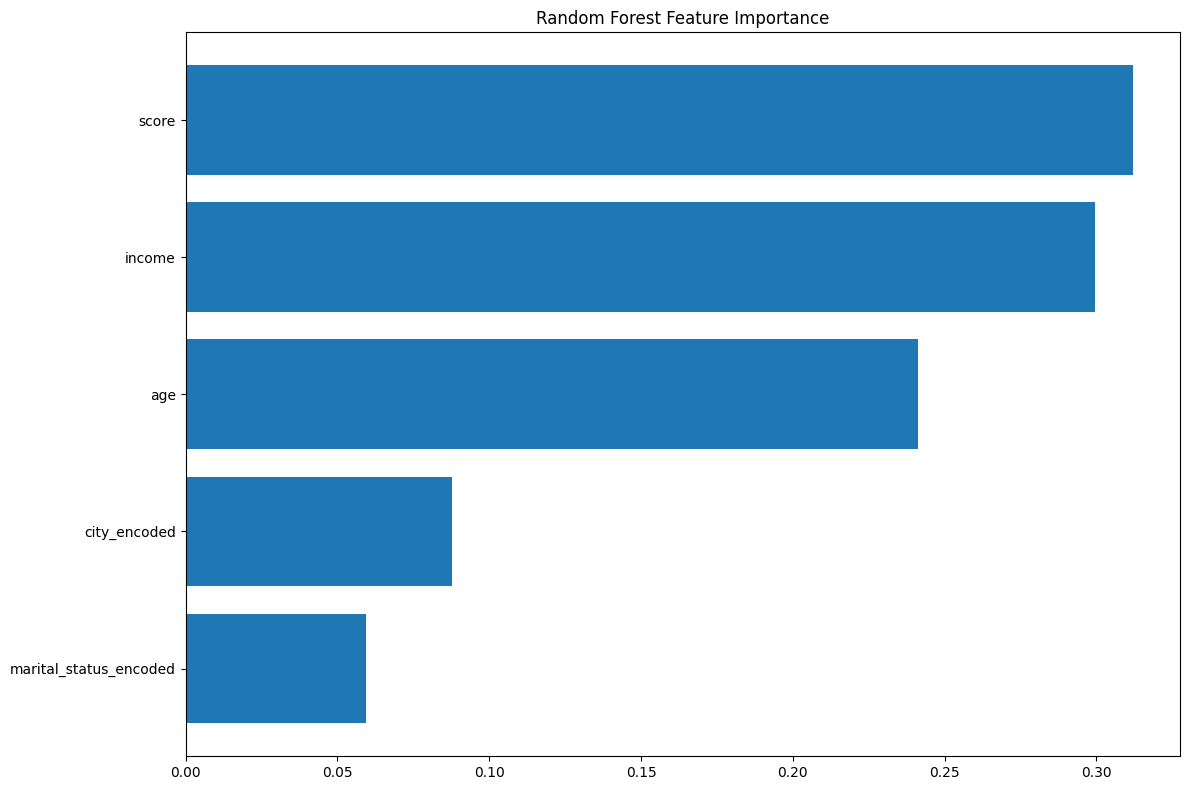

Cross-validation scores: [0.69767442 0.70930233 0.69411765 0.62352941 0.76470588]
Mean CV accuracy: 0.6979
Standard deviation: 0.0450
-------------------------------------------------------------------------------------------------------------------------------


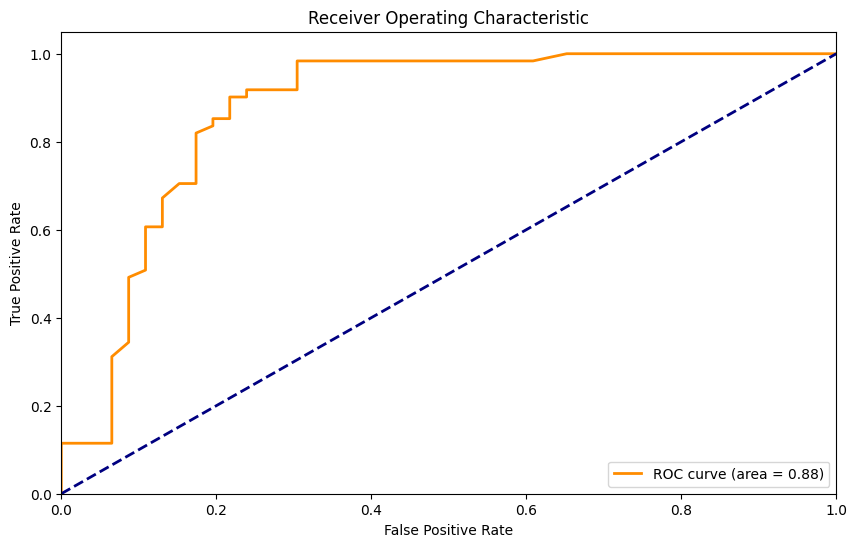

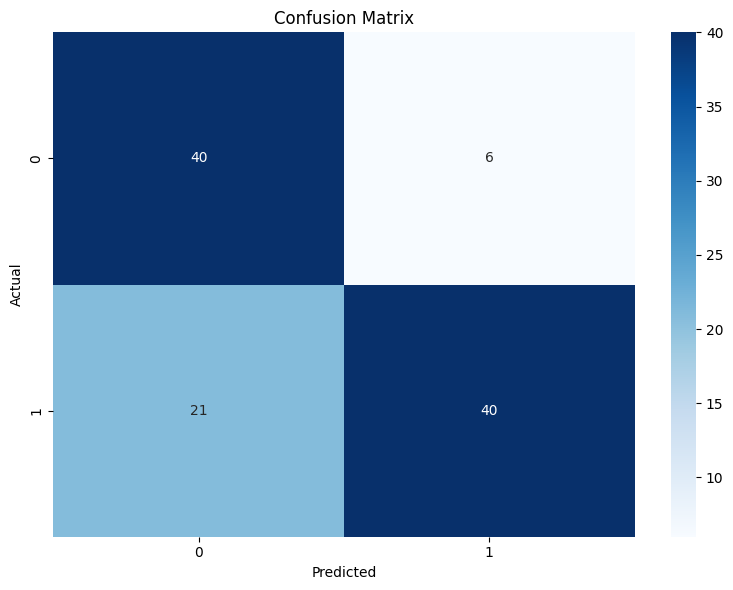

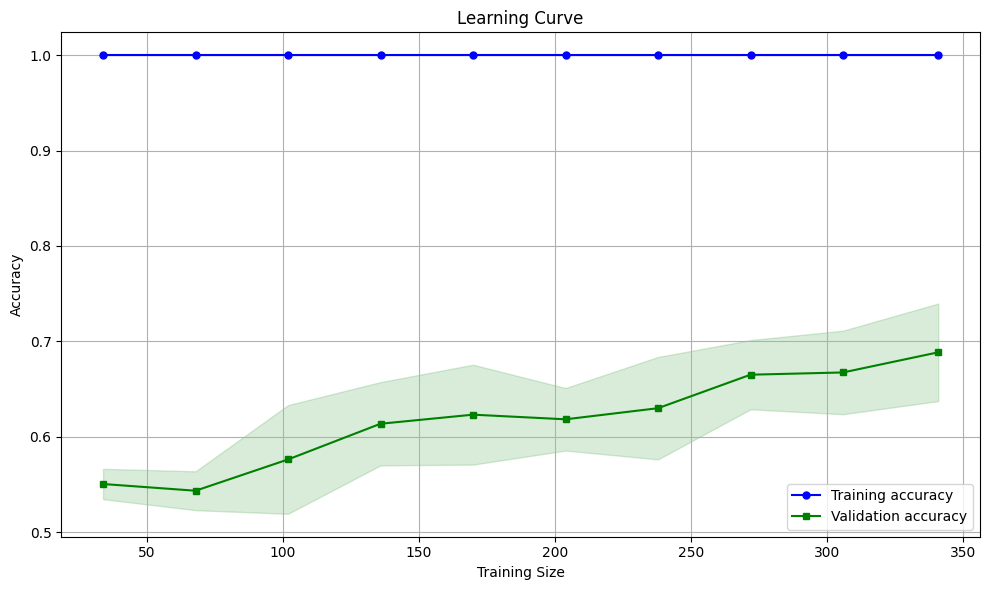

--- Fine-tuning n_estimators ---
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fine-tuned n_estimators: 180
Fine-tuned accuracy: 0.6979
-------------------------------------------------------------------------------------------------------------------------------
--- Final Optimized Model Results ---
Final parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 180}
Accuracy Test: 0.7383
Accuracy Train: 1.0000
Classification Report:

Classification Report Test: 
               precision    recall  f1-score   support

           0       0.65      0.87      0.74        46
           1       0.87      0.64      0.74        61

    accuracy                           0.74       107
   macro avg       0.76      0.75      0.74       107
weighted avg       0.77      0.74      0.74       107
 

Classification Report Train: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       221
           1       1.00      1.0

In [25]:
# RandomForest Tuning 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.datasets import load_breast_cancer

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset (binary classification)
X = df.drop(columns=['purchased'], axis=1)
y = df['purchased']

# Print dataset information
print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print() 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

# Features and target names
feature_names = X.columns
target_names = ['0', '1']

# Feature scaling (optional for RandomForest but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Basic Random Forest model (baseline)
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train_scaled, y_train)
y_pred_base = rf_base.predict(X_test_scaled)
y_pred_base_train = rf_base.predict(X_train_scaled)

print("--- Baseline Random Forest Results ---")
print(f"Accuracy Test set: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"Accuracy Train set: {accuracy_score(y_train, y_pred_base_train):.4f}")
print("Classification Report:")
print("Classification Report Test:",'\n', classification_report(y_test, y_pred_base, target_names=target_names),'\n')
print("Classification Report Train:",'\n', classification_report(y_train, y_pred_base_train, target_names=target_names))
print('-' *127)

# 2. GridSearchCV for hyperparameter tuning
print("--- Grid Search Hyperparameter Tuning ---")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use smaller param_grid for demonstration purposes (to avoid long execution time)
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=small_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
print('-' *127)

# 3. RandomizedSearchCV (more efficient for large parameter spaces)
print("--- Randomized Search Hyperparameter Tuning ---")
random_grid = {
    'n_estimators': np.arange(100, 500, 100),
    'max_depth': [None] + list(np.arange(10, 50, 10)),
    'min_samples_split': np.arange(2, 12, 2),
    'min_samples_leaf': np.arange(1, 5),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

randomized_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=random_grid,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
    random_state=42
)

randomized_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {randomized_search.best_params_}")
print(f"Best cross-validation score: {randomized_search.best_score_:.4f}")
print('-' *127)

# 4. Evaluate the best model from GridSearchCV
best_grid_model = grid_search.best_estimator_
y_pred_grid = best_grid_model.predict(X_test_scaled)
y_pred_grid_train = best_grid_model.predict(X_train_scaled)
y_prob_grid = best_grid_model.predict_proba(X_test_scaled)[:, 1]

print("--- Best Grid Search Model Evaluation ---")
print(f"Accuracy Test: {accuracy_score(y_test, y_pred_grid):.4f}")
print(f"Accuracy Train: {accuracy_score(y_train, y_pred_grid_train):.4f}")
print("Classification Report:\n")
print("Classification Report Test:",'\n', classification_report(y_test, y_pred_grid, target_names=target_names),'\n')
print("Classification Report Train:",'\n', classification_report(y_train, y_pred_grid_train, target_names=target_names))
print('-' *127)

# 5. Feature importance analysis
feature_importances = best_grid_model.feature_importances_
sorted_idx = np.argsort(feature_importances)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title('Random Forest Feature Importance')
plt.tight_layout()
#plt.savefig('feature_importance.png')
#plt.close()
plt.show()

# 6. Cross-validation of the best model
cv_scores = cross_val_score(best_grid_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")
print('-' *127)

# 7. ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_grid)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.savefig('roc_curve.png')
#plt.close()
plt.show()

# 8. Confusion Matrix visualization
cm = confusion_matrix(y_test, y_pred_grid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
#plt.savefig('confusion_matrix.png')
#plt.close()
plt.show()

# 9. Learning curves (optional for deeper analysis)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_grid_model, X_train_scaled, y_train, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('learning_curve.png')
#plt.close()
plt.show()

# 10. Fine-tuning specific parameters (optional based on previous findings)
# For example, fine-tuning n_estimators after discovering optimal ranges
print("--- Fine-tuning n_estimators ---")
estimator_range = np.arange(best_grid_model.n_estimators - 50, best_grid_model.n_estimators + 60, 10)
estimator_range = estimator_range[estimator_range > 0]  # Ensure positive values

param_grid_fine = {
    'n_estimators': estimator_range
}

# Create a new RF with the best parameters from before
rf_fine = RandomForestClassifier(
    random_state=42,
    max_depth=best_grid_model.max_depth,
    min_samples_split=best_grid_model.min_samples_split,
    # Add other parameters from best_grid_model as needed
)

grid_search_fine = GridSearchCV(
    estimator=rf_fine,
    param_grid=param_grid_fine,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_search_fine.fit(X_train_scaled, y_train)
print(f"Fine-tuned n_estimators: {grid_search_fine.best_params_['n_estimators']}")
print(f"Fine-tuned accuracy: {grid_search_fine.best_score_:.4f}")
print('-' *127)

# 11. Final model with all optimized parameters
final_params = grid_search.best_params_.copy()
final_params['n_estimators'] = grid_search_fine.best_params_['n_estimators']

final_model = RandomForestClassifier(random_state=42, **final_params)
final_model.fit(X_train_scaled, y_train)
y_pred_final = final_model.predict(X_test_scaled)
y_pred_final_train = final_model.predict(X_train_scaled)

print("--- Final Optimized Model Results ---")
print(f"Final parameters: {final_params}")
print(f"Accuracy Test: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Accuracy Train: {accuracy_score(y_train, y_pred_final_train):.4f}")
print("Classification Report:\n")
print("Classification Report Test:",'\n', classification_report(y_test, y_pred_final, target_names=target_names),'\n')
print("Classification Report Train:",'\n', classification_report(y_train, y_pred_final_train, target_names=target_names))
print('-' *127)

# Compare basic and tuned models
print("--- Model Comparison ---")
print(f"Basic Model Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"Basic Model Accuracy Pipeline Grid: {accuracy_score(y_test, y_pred_grid):.4f}")
print(f"Tuned Model Accuracy GridSearch: {accuracy_score(y_test, y_pred_final):.4f}\n")

# Calculate cross-validation scores for both models
cv_scores_basic_rf = cross_val_score(rf_base, X, y, cv=5, scoring='accuracy')
cv_scores_basic_rf_grid = cross_val_score(best_grid_model, X, y, cv=5, scoring='accuracy')
cv_scores_tuned_rf_grid = cross_val_score(final_model, X, y, cv=5, scoring='accuracy')

print(f"Basic Model Logistic Regression Cross-Validation Scores: {cv_scores_basic_rf}")
print(f"Basic Model Pipeline Cross-Validation Scores: {cv_scores_basic_rf_grid}")
print(f"Tuned Model Grid Search Cross-Validation Scores: {cv_scores_tuned_rf_grid}\n")

print(f"Basic Model Average CV Score RF:      {cv_scores_basic_rf.mean():.4f} ± {cv_scores_basic_rf.std():.4f}")
print(f"Basic Model Average CV Score Pipe RF: {cv_scores_basic_rf_grid.mean():.4f} ± {cv_scores_basic_rf_grid.std():.4f}")
print(f"Tuned Model Average CV Score Grid RF: {cv_scores_tuned_rf_grid.mean():.4f} ± {cv_scores_tuned_rf_grid.std():.4f}")
print("-" * 127)  

## AdaBoostClassifier

Dataset shape: (534, 5)
Feature names: Index(['age', 'income', 'score', 'city_encoded', 'marital_status_encoded'], dtype='object')
Number of classes: 2
Class distribution: [267 267]

X Train shape: (427, 5)
Y Train shape: (427,)
X Test shape: (107, 5)
Y Test shape: (107,)
-------------------------------------------------------------------------------------------------------------------------------

--- Basic AdaBoost Model ---
Accuracy test set: 0.4579
Accuracy train set: 0.6042

 --- Classification Report: ---
Classification Report test set:
               precision    recall  f1-score   support

           0       0.43      0.76      0.55        46
           1       0.56      0.23      0.33        61

    accuracy                           0.46       107
   macro avg       0.49      0.50      0.44       107
weighted avg       0.50      0.46      0.42       107


Classification Report train set:
               precision    recall  f1-score   support

           0       0.57      0.90

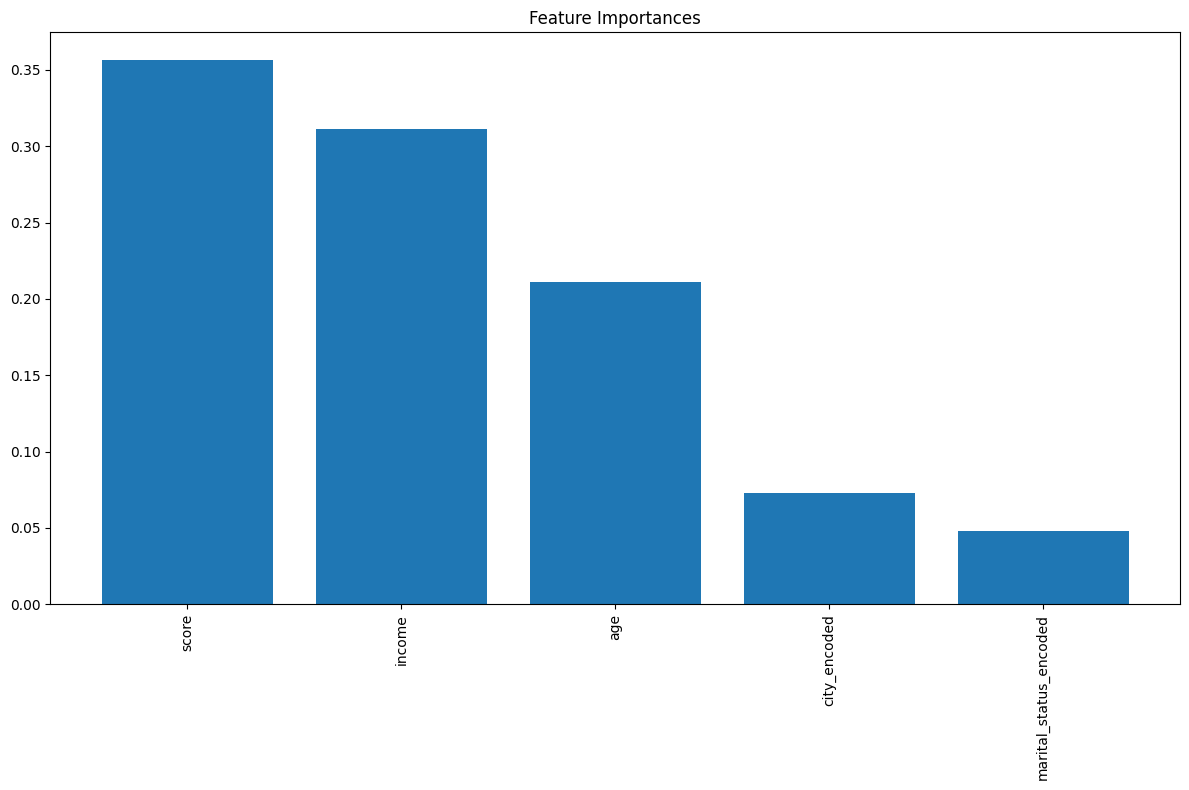


--- Confusion Matrix ---


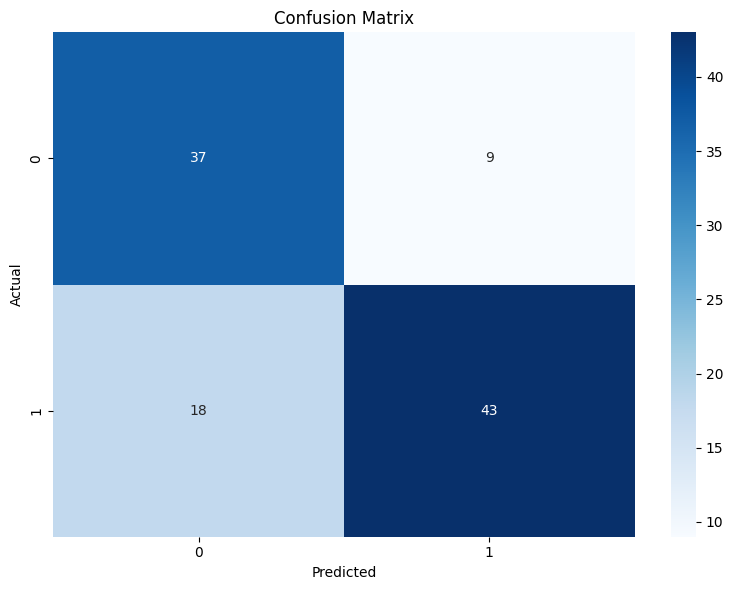


--- ROC Curve ---


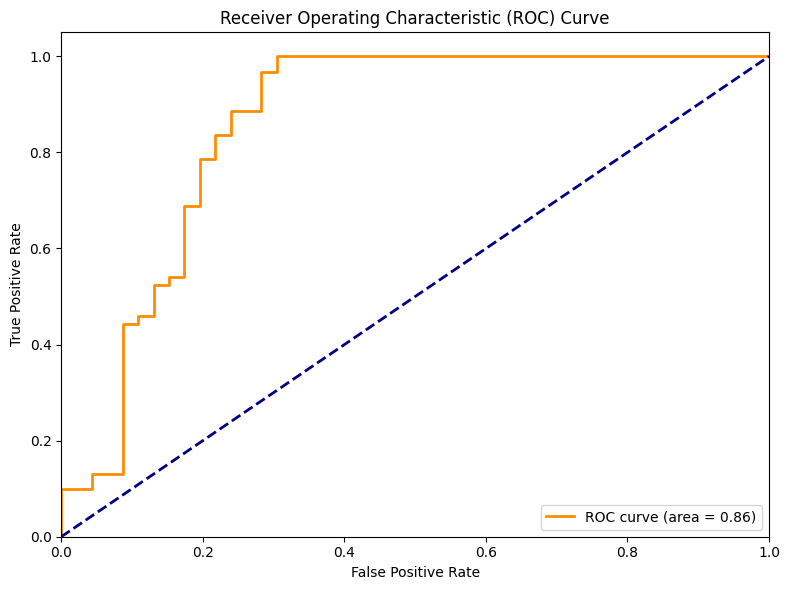


--- Learning Curve ---


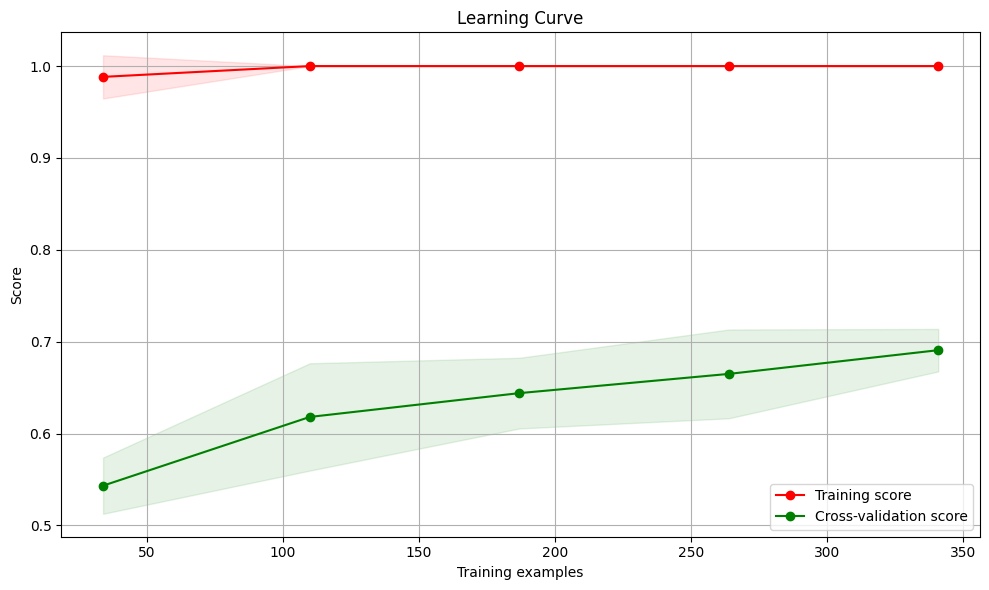


--- Effect of Learning Rate ---


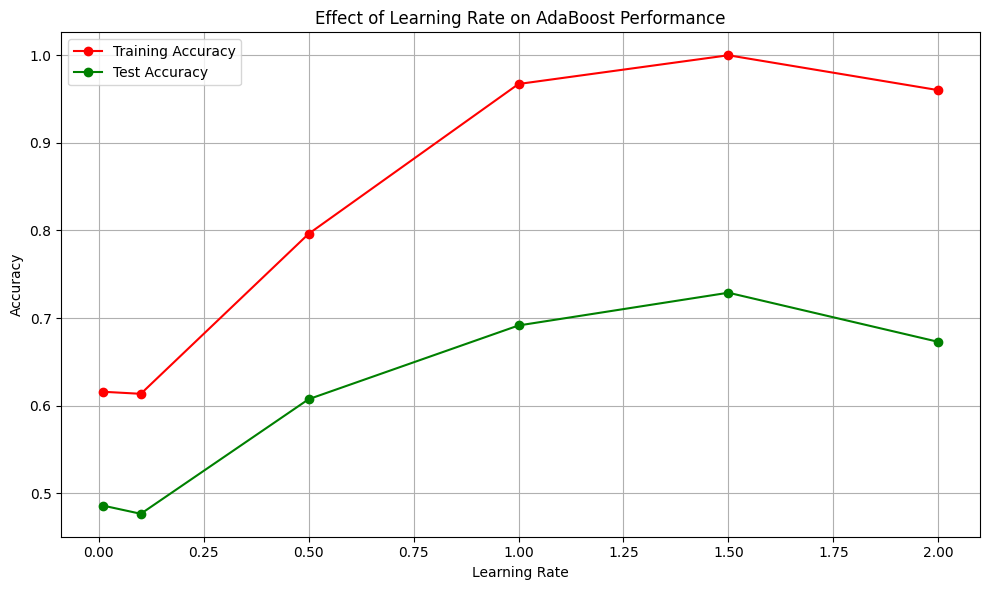


--- Effect of Number of Estimators ---


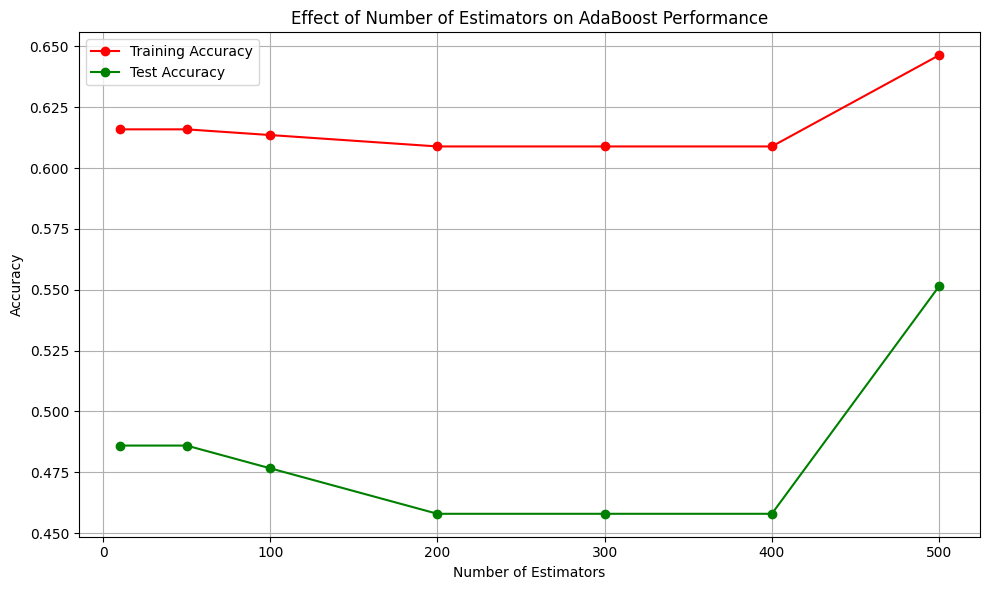


--- Pipeline with AdaBoost ---
Best pipeline parameters: {'adaboost__n_estimators': 50, 'adaboost__learning_rate': 1.0, 'adaboost__estimator': DecisionTreeClassifier(max_depth=3, random_state=42)}
Best cross-validation score: 0.6815

Pipeline test accuracy:  0.6916
Pipeline train accuracy: 0.9227

--- Model Comparison ---
Base AdaBoost accuracy: 0.4579
Grid Search tuned accuracy: 0.7477
Pipeline tuned accuracy: 0.6916
Basic Model Logistic Regression Cross-Validation Scores: [0.58878505 0.52336449 0.58878505 0.57943925 0.55660377]
Basic Model Pipeline Cross-Validation Scores: [0.78504673 0.70093458 0.73831776 0.71962617 0.81132075]
Tuned Model Grid Search Cross-Validation Scores: [0.6635514  0.58878505 0.64485981 0.6635514  0.71698113]

Basic Model Average CV Score ADA:      0.5674 ± 0.0250
Basic Model Average CV Score Pipe ADA: 0.7510 ± 0.0411
Tuned Model Average CV Score Grid ADA: 0.6555 ± 0.0412
----------------------------------------------------------------------------------------

In [26]:
# Set random seed for reproducibility
np.random.seed(42)

# Prepare the data
X = df.drop(columns=['purchased'], axis=1)
y = df['purchased'] 

# Print dataset information
print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print() 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Basic AdaBoost model with default parameters
print("\n--- Basic AdaBoost Model ---")
base_model = AdaBoostClassifier(random_state=42, algorithm='SAMME')
base_model.fit(X_train_scaled, y_train)
y_pred = base_model.predict(X_test_scaled)
y_pred_train = base_model.predict(X_train_scaled)

print(f"Accuracy test set: {accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy train set: {accuracy_score(y_train, y_pred_train):.4f}")
print("\n --- Classification Report: ---")
print(f"Classification Report test set:\n {classification_report(y_test, y_pred)}\n")
print(f"Classification Report train set:\n {classification_report(y_train, y_pred_train)}")

# Grid search for hyperparameter tuning
print("\n--- Grid Search for Hyperparameter Tuning ---")
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [1, 3, 5]
}

# Create base estimator
base_estimator = DecisionTreeClassifier(random_state=42)

# Create AdaBoost model
adaboost = AdaBoostClassifier(estimator=base_estimator, random_state=42, algorithm='SAMME')

# Create grid search
grid_search = GridSearchCV(
    estimator=adaboost,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

# Fit grid search
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}\n")

# Train model with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_grid = best_model.predict(X_test_scaled)
y_pred_grid_train = best_model.predict(X_train_scaled)
print(f"Test accuracy with best model test set: {accuracy_score(y_test, y_pred_grid):.4f}")
print(f"Test accuracy with best model train set: {accuracy_score(y_train, y_pred_grid_train):.4f}")

# Visualize feature importances
def plot_feature_importance(model, feature_names):
    # For AdaBoost, feature_importances_ is available after fitting
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        # For pipeline, need to access the classifier
        importances = model.named_steps['adaboost'].feature_importances_
    
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(indices[:15])), importances[indices[:15]], align='center')
    plt.xticks(range(len(indices[:15])), [feature_names[i] for i in indices[:15]], rotation=90)
    plt.tight_layout()
    plt.show()

print("\n--- Feature Importances ---")
plot_feature_importance(best_model, X_train.columns)

# confusion matrix 
def plot_confusion_matrix(y_true, y_pred, classes=None):
    cm = confusion_matrix(y_true, y_pred)
    
    # If classes not provided, determine them automatically
    if classes is None:
        classes = sorted(set(y_true) | set(y_pred))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

print("\n--- Confusion Matrix ---")
plot_confusion_matrix(y_test, y_pred_grid)

# ROC curve
def plot_roc_curve(model, X, y):
    y_score = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

print("\n--- ROC Curve ---")
plot_roc_curve(best_model, X_test_scaled, y_test)

# Learning curve
def plot_learning_curve(estimator, X, y, title="Learning Curve", ylim=None, cv=5, n_jobs=-1):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=np.linspace(.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

print("\n--- Learning Curve ---")
plot_learning_curve(best_model, X_train_scaled, y_train)

# Effect of different learning rates
def plot_learning_rate_effect():
    learning_rates = [0.01, 0.1, 0.5, 1.0, 1.5, 2.0]
    train_scores = []
    test_scores = []
    
    for lr in learning_rates:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=3),
            n_estimators=100,
            learning_rate=lr,
            algorithm='SAMME',
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        train_scores.append(accuracy_score(y_train, model.predict(X_train_scaled)))
        test_scores.append(accuracy_score(y_test, model.predict(X_test_scaled)))
    
    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates, train_scores, 'o-', color='r', label='Training Accuracy')
    plt.plot(learning_rates, test_scores, 'o-', color='g', label='Test Accuracy')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.title('Effect of Learning Rate on AdaBoost Performance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n--- Effect of Learning Rate ---")
plot_learning_rate_effect()

# Effect of number of estimators
def plot_n_estimators_effect():
    n_estimators_range = [10, 50, 100, 200, 300, 400, 500]
    train_scores = []
    test_scores = []
    
    for n_est in n_estimators_range:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=3),
            n_estimators=n_est,
            learning_rate=0.1,
            algorithm='SAMME',
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        train_scores.append(accuracy_score(y_train, model.predict(X_train_scaled)))
        test_scores.append(accuracy_score(y_test, model.predict(X_test_scaled)))
    
    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_range, train_scores, 'o-', color='r', label='Training Accuracy')
    plt.plot(n_estimators_range, test_scores, 'o-', color='g', label='Test Accuracy')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.title('Effect of Number of Estimators on AdaBoost Performance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n--- Effect of Number of Estimators ---")
plot_n_estimators_effect()

# Pipeline example with AdaBoost
print("\n--- Pipeline with AdaBoost ---")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('adaboost', AdaBoostClassifier(random_state=42, algorithm='SAMME'))
])

# Parameters for pipeline
pipeline_params = {
    'adaboost__estimator': [DecisionTreeClassifier(max_depth=1, random_state=42),
                           DecisionTreeClassifier(max_depth=3, random_state=42)],
    'adaboost__n_estimators': [50, 100, 200],
    'adaboost__learning_rate': [0.01, 0.1, 1.0]
}

# Randomized search to speed up the tuning process
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=pipeline_params,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Fit randomized search
random_search.fit(X_train, y_train)  # Note: Using unscaled data since scaling is part of the pipeline

# Print best parameters
print(f"Best pipeline parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}\n")

# Evaluate the best pipeline model
best_pipeline = random_search.best_estimator_
y_pred_pipeline = best_pipeline.predict(X_test)
y_pred_pipeline_train = best_pipeline.predict(X_train)
print(f"Pipeline test accuracy:  {accuracy_score(y_test, y_pred_pipeline):.4f}")
print(f"Pipeline train accuracy: {accuracy_score(y_train, y_pred_pipeline_train):.4f}")

# Compare basic and tuned models
print("\n--- Model Comparison ---")
print(f"Base AdaBoost accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Grid Search tuned accuracy: {accuracy_score(y_test, y_pred_grid):.4f}")
print(f"Pipeline tuned accuracy: {accuracy_score(y_test, y_pred_pipeline):.4f}")

# Calculate cross-validation scores for both models
cv_scores_basic_ada = cross_val_score(base_model, X, y, cv=5, scoring='accuracy')
cv_scores_basic_ada_grid = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
cv_scores_tuned_ada_grid = cross_val_score(best_pipeline, X, y, cv=5, scoring='accuracy')

print(f"Basic Model Logistic Regression Cross-Validation Scores: {cv_scores_basic_ada}")
print(f"Basic Model Pipeline Cross-Validation Scores: {cv_scores_basic_ada_grid}")
print(f"Tuned Model Grid Search Cross-Validation Scores: {cv_scores_tuned_ada_grid}\n")

print(f"Basic Model Average CV Score ADA:      {cv_scores_basic_ada.mean():.4f} ± {cv_scores_basic_ada.std():.4f}")
print(f"Basic Model Average CV Score Pipe ADA: {cv_scores_basic_ada_grid.mean():.4f} ± {cv_scores_basic_ada_grid.std():.4f}")
print(f"Tuned Model Average CV Score Grid ADA: {cv_scores_tuned_ada_grid.mean():.4f} ± {cv_scores_tuned_ada_grid.std():.4f}")
print("-" * 127) 

# Print final classification report
print("\nFinal Classification Report:")
print(f"Base AdaBoost accuracy:\n {classification_report(y_test, y_pred)}\n")
print(f"Grid Search tuned accuracy:\n {classification_report(y_test, y_pred_grid)}\n")
print(f"Pipeline tuned accuracy:\n {classification_report(y_test, y_pred_pipeline)}")

## BaggingClassifier

Dataset shape: (534, 5)
Feature names: Index(['age', 'income', 'score', 'city_encoded', 'marital_status_encoded'], dtype='object')
Number of classes: 2
Class distribution: [267 267]

X Train shape: (427, 5)
Y Train shape: (427,)
X Test shape: (107, 5)
Y Test shape: (107,)
-------------------------------------------------------------------------------------------------------------------------------
BaggingClassifier Accuracy test set: 0.6916
BaggingClassifier Accuracy train set: 0.9813
Starting grid search...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Grid search completed!

Best parameters: {'bootstrap': False, 'bootstrap_features': True, 'estimator__max_depth': None, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}
Best cross-validation score: 0.7002

Tuned BaggingClassifier Accuracy: 0.7009
Improvement: 0.0093

Classification Report for Tuned Model:
              precision    recall  f1-score   support

           0       0.61      0.83      0.70     

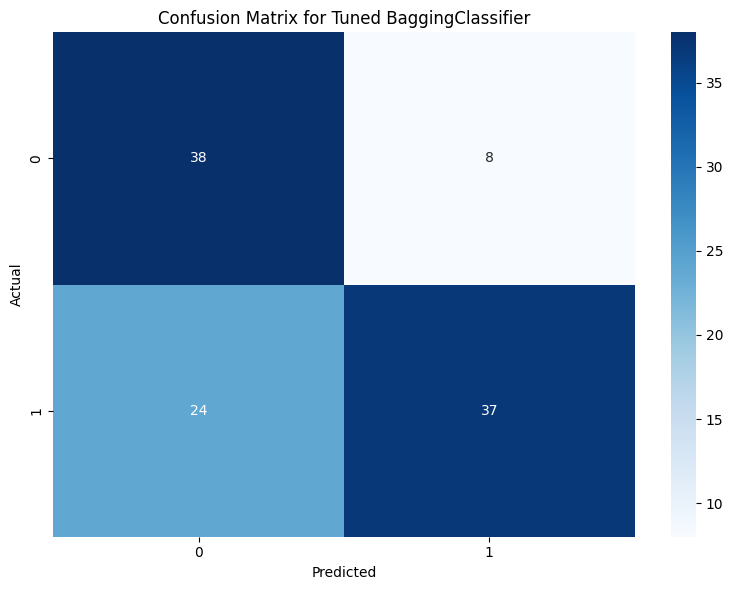

Feature importances not available for this model

--- Model Comparison ---
Base Bagging accuracy: 0.6916
Grid Search tuned accuracy: 0.7009


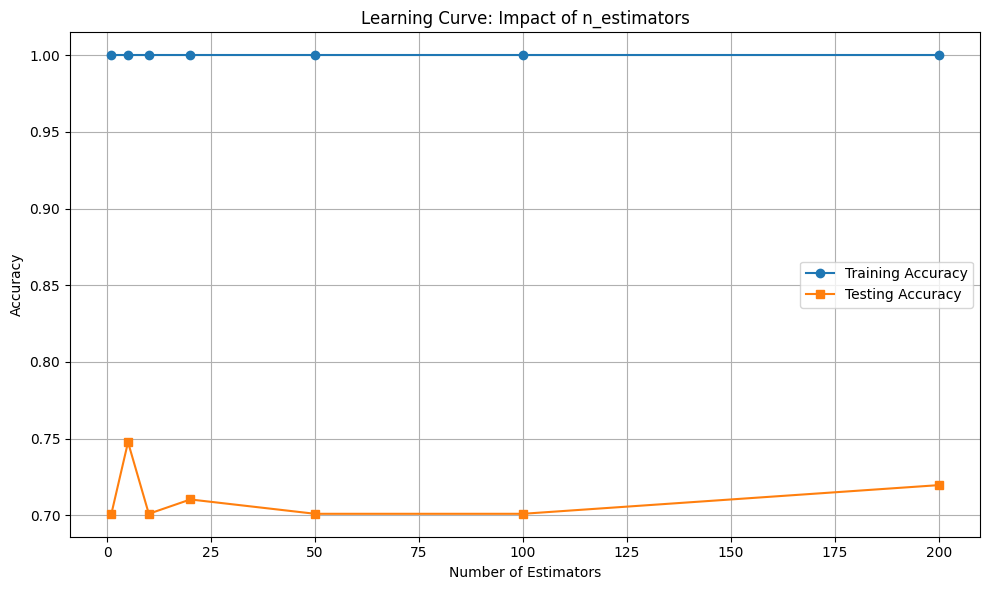

In [27]:
# Bagging Tuning 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Prepare the data
X = df.drop(columns=['purchased'], axis=1)
y = df['purchased']

# Print dataset information
print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print() 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a base classifier (Decision Tree in this case)
base_clf = DecisionTreeClassifier(random_state=42)

# Create and train a simple BaggingClassifier with default parameters
bag_clf = BaggingClassifier(estimator=base_clf, random_state=42)
bag_clf.fit(X_train_scaled, y_train)

# Evaluate initial model
y_pred = bag_clf.predict(X_test_scaled)
y_pred_train = bag_clf.predict(X_train_scaled)

# Initial accuracy
initial_accuracy = accuracy_score(y_test, y_pred)

print(f"BaggingClassifier Accuracy test set: {accuracy_score(y_test, y_pred):.4f}")
print(f"BaggingClassifier Accuracy train set: {accuracy_score(y_train, y_pred_train):.4f}")

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'estimator__max_depth': [None, 5, 10]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=BaggingClassifier(estimator=base_clf, random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV to find best parameters
print("Starting grid search...")
grid_search.fit(X_train_scaled, y_train)
print("Grid search completed!")

# Get best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}\n")

# Get the best model
best_bag_clf = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = best_bag_clf.predict(X_test_scaled)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"Tuned BaggingClassifier Accuracy: {tuned_accuracy:.4f}")
print(f"Improvement: {tuned_accuracy - initial_accuracy:.4f}")

# Generate classification report
print("\nClassification Report for Tuned Model:")
print(classification_report(y_test, y_pred_tuned))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_tuned)
classes = sorted(y_test.unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, 
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Tuned BaggingClassifier')
plt.tight_layout()
plt.show()

# Visualize feature importance (if available)
if hasattr(best_bag_clf, 'feature_importances_'):
    feature_importances = best_bag_clf.estimator_.feature_importances_
    feature_names = X_train.columns
    
    # Get top 10 features
    indices = np.argsort(feature_importances)[::-1][:10]
    
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Feature Importances')
    plt.bar(range(10), feature_importances[indices])
    plt.xticks(range(10), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for this model")

# Analyzing the impact of n_estimators
n_estimators_range = [1, 5, 10, 20, 50, 100, 200]
train_scores = []
test_scores = []

for n_estimators in n_estimators_range:

    # Create model with current n_estimators value
    bag = BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=best_bag_clf.estimator_.max_depth),
        n_estimators=n_estimators,
        max_samples=best_bag_clf.max_samples,
        max_features=best_bag_clf.max_features,
        bootstrap=best_bag_clf.bootstrap,
        bootstrap_features=best_bag_clf.bootstrap_features,
        random_state=42
    )
    
    # Train model
    bag.fit(X_train_scaled, y_train)
    
    # Evaluate on train and test sets
    train_score = accuracy_score(y_train, bag.predict(X_train_scaled))
    test_score = accuracy_score(y_test, bag.predict(X_test_scaled))
    
    train_scores.append(train_score)
    test_scores.append(test_score)

# Compare basic and tuned models
print("\n--- Model Comparison ---")
print(f"Base Bagging accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Grid Search tuned accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}") 

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, label='Training Accuracy', marker='o')
plt.plot(n_estimators_range, test_scores, label='Testing Accuracy', marker='s')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Impact of n_estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### These models were overfitting so they're not taken as a reference of deployment, 
#### however these models show you how I implement and build these models

In [28]:
df.head()

,age,income,score,purchased,city_encoded,marital_status_encoded
0,46,90588,0.685968,1,0,2
1,38,89449,0.580112,1,3,0
2,36,109643,0.521730,1,3,1
3,28,106027,0.532245,1,4,0
4,41,23373,0.132715,1,1,2
